In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project, Statistics, JLD2

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


## Perform error analysis on MJO predictions

### prepare data

In [3]:
# load data
header = ["year", "month", "day", "hour", "PC1 coeff", "PC2 coeff", "PC1+PC2 amplitude"]
data = CSV.read("data/mjo_data/mjo_romi.txt", DataFrame; delim=" ", ignorerepeated=true, header=header)
pc1 = data[!,"PC1 coeff"]
pc2 = data[!,"PC2 coeff"];

# perform TDE
D1, τ1, E1 = optimal_separated_de(pc1)
D2, τ2, E2 = optimal_separated_de(pc2);
D1, D2 = Matrix(transpose(Matrix(D1))), Matrix(transpose(Matrix(D2)));

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


In [4]:
# train, test, val splits
train_size = 10000
val_size = 2000
test_size = size(D1,2) - train_size - val_size

"""train_pc1, train_pc2 = D1[:, 1:train_size],  D2[:, 1:train_size]
val_pc1, val_pc2 = D1[:, train_size+1:train_size+val_size], D2[:, train_size+1:train_size+val_size]
test_pc1, test_pc2 = D1[:, train_size+val_size+1:train_size+val_size+test_size], D2[:, train_size+val_size+1:train_size+val_size+test_size];"""

"train_pc1, train_pc2 = D1[:, 1:train_size],  D2[:, 1:train_size]\nval_pc1, val_pc2 = D1[:, train_size+1:train_size+val_size], D2[:, train_size+1:train_size+val_size]\ntest_pc1, test_pc2 = D1[:, train_size+val_size+1:train_size+val_size+test_size], D2[:, train_size+val_size+1:train_size+val_size+test_size];"

### gather prediction samples

In [5]:
# sample size N
N = 20

# lead time L
L = 60;

### training

In [ ]:
spectral_radii = [0.8,0.9]
sparsities = [0.14,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5]
reservoir_sizes = [500,600]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [7]:
function sample_lead_times(L, N, data, train_size, initial_val_size, param_grid)
    datasets_test = zeros(N,L)
    predictions = zeros(N,L)

    for n in 0:(N-1)
        # include data shift n
        train_data = data[:, 1:train_size]
        val_data = data[:, train_size+1:train_size+initial_val_size+n]
        test_data = data[:, train_size+initial_val_size+n+1:train_size+initial_val_size+n+L]

        # train
        esn, W_out, val_loss = enso_project.cross_validate_esn(train_data, val_data, param_grid) 
        prediction = enso_project.esn_eval_pred(esn, W_out, test_data)

        # store 
        datasets_test[n+1,:] = test_data[1,:]
        predictions[n+1,:] = prediction

        # progress control
        println("Finished sample $(n+1)")
    end
    return predictions, datasets_test
end

sample_lead_times (generic function with 1 method)

In [8]:
# pc1
predictions_pc1, datasets_test_pc1 = sample_lead_times(L,N,D1, train_size, val_size,param_grid)


enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15044.143070206772
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 14028.332117730697
Finished sample 1
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15049.769417189069
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 14034.160924459913
Finished sample 2
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15055.31654451148
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 14040.732893558747
Finished sample 3
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15061.288184875822
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 14047.76253655364
Finished sample 4
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15068.150228201383
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 14054.324592295316
Finished sample 5
enso_pr

([-0.27566749046206046 -0.4180764487501046 … 1.3414115528832302 1.0233338669390457; -0.40804194034149066 -0.5183064150309199 … 1.0463184013590061 0.677434514003485; … ; 0.5282786598038703 0.4615452105459196 … -1.9987387160596006 -1.9454771510772946; 0.45221182638527896 0.3673062446090089 … -1.8522423000778376 -1.785653932265118], [-0.26594 -0.4044 … 1.12644 0.92548; -0.4044 -0.48163 … 0.92548 0.70306; … ; 0.52513 0.44363 … -1.51296 -1.4921; 0.44363 0.36481 … -1.4921 -1.47315])

In [9]:

CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_predictions_pc1.csv", DataFrame(predictions_pc1, :auto))
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_testsets_pc1.csv", DataFrame(datasets_test_pc1, :auto))

"C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L60_N20_testsets_pc1.csv"

In [10]:
# pc2
predictions_pc2, datasets_test_pc2 = sample_lead_times(L,N,D2, train_size, val_size,param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 11115.251050486528
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 0.0)
Validation loss = 10071.460218223527
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 1.0e-5)
Validation loss = 10070.720541312765
Finished sample 1
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 11124.885633472732
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 0.0)
Validation loss = 10080.531838901337
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 1.0e-5)
Validation loss = 10079.79026023571
Finished sample 2
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 11134.786313250788
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 0.0)
Validation loss = 10089.721351230302
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 1.0e-5)
Validation loss = 10088.97044303601
Finished sample 3
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 11144.757477298623
enso_project.ESNHyperparams(500, 0.

([0.2695400922874172 0.34174090082166375 … 1.4176161609014564 1.658432352437017; 0.3514524110088816 0.42217928173667474 … 1.4905686612089901 1.7185477062290295; … ; 1.1171125736631498 1.0986960183488612 … 1.339055338522416 1.1223550978608319; 1.0450950306278348 1.007337851286961 … 1.1448785243111539 0.8941680533007735], [0.26534 0.36134 … 1.24953 1.41313; 0.36134 0.49521 … 1.41313 1.52727; … ; 1.08401 1.01613 … 0.9273 0.60305; 1.01613 0.96402 … 0.60305 0.31385])

In [11]:

CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_predictions_pc2.csv", DataFrame(predictions_pc2, :auto))
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_testsets_pc2.csv", DataFrame(datasets_test_pc2, :auto))

"C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L60_N20_testsets_pc2.csv"

### error analysis

In [38]:
"""
    function rmse(predictions::AbstractMatrix, test_data::AbstractMatrix, predictions2::AbstractMatrix, test_data2::AbstractMatrix)
       
compute the rmse between predicitons and test data for each lead time. Is considered good if smaller 1.4.

# Arguments:
    - `predicitons::AbstractMatrix`: predictions, NxL matrix. N is sample size per lead time, L is all lead times considered
    - `test_data::AbstractMatrix`: test data for each sample, NxL matrix.
    - `predicitons2::AbstractMatrix`: predictions of second component, NxL matrix. N is sample size per lead time, L is all lead times considered
    - `test_data2::AbstractMatrix`: test data of second component for each sample, NxL matrix.

# Returns:
    - `Vector`: RMSE for each lead time, vector of length L
"""
function rmse(predictions::AbstractMatrix, test_data::AbstractMatrix, predictions2::AbstractMatrix, test_data2::AbstractMatrix)
    N, L = size(predictions, 1), size(predictions,2)
    sse_vals = zeros(N,L)
    sse_vals = (predictions .- test_data).^2 .+ (predictions2 .- test_data2).^2
    rmse = sqrt.(sum(sse_vals, dims=1) ./N)
    return rmse[1,:]
end


rmse

In [46]:

"""
    function bivariate_corr(predictions::AbstractMatrix, test_data::AbstractMatrix, predictions2::AbstractMatrix, test_data2::AbstractMatrix)

Compute the bivariate correlation coefficient between sample and test data for each lead time considered.
Inputs are N×L matrices: rows = samples, cols = lead times.
Formula from paper: "Improving the Predictability of the Madden-Julian Oscillation at Subseasonal Scales With Gaussian Process Models" by Chen H. et al.

# Arguments:
    - `predicitons::AbstractMatrix`:  predictions, NxL matrix. N is sample size per lead time, L is all lead times considered
    - `test_data::AbstractMatrix`: test data for each sample, NxL matrix.
    - `predicitons2::AbstractMatrix`:  predictions of second component, NxL matrix. N is sample size per lead time, L is all lead times considered
    - `test_data2::AbstractMatrix`: test data of second component for each sample, NxL matrix.

# Returns:
    - `Vector`: PCC for each lead time, vector of length L
"""
function bivariate_corr(predictions::AbstractMatrix, test_data::AbstractMatrix, predictions2::AbstractMatrix, test_data2::AbstractMatrix)

    L = size(test_data, 2)
    corrs = zeros(L) # obtain correlation for each lead time

    for l in 1:L
        # vectors of data at lead time l
        z1 = test_data[:,l]
        z2 = test_data2[:,l]
        zh1 = predictions[:,l]
        zh2 = predictions2[:,l]

        num   = sum(z1 .* zh1 .+ z2 .* zh2) # element-wise product summed over sample N
        denom = sqrt(sum(z1.^2 .+ z2.^2)) * sqrt(sum(zh1.^2 .+ zh2.^2))

        corrs[l] = num / denom
    end

    return corrs
end

bivariate_corr

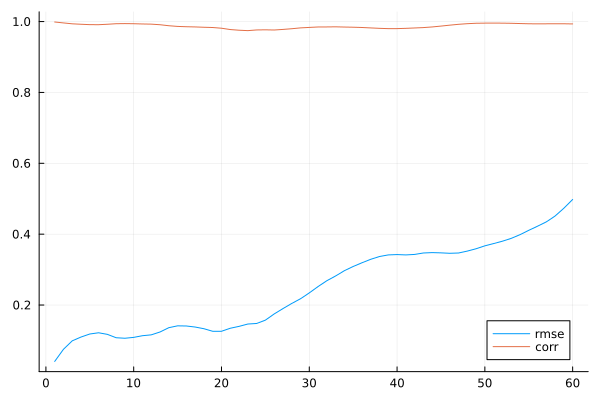

In [47]:
rmse_vals = rmse(predictions_pc1, datasets_test_pc1, predictions2=predictions_pc2, test_data2=datasets_test_pc2)
corr_vals = bivariate_corr(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
plot(rmse_vals, label="rmse")
plot!(corr_vals,label="corr")

In [126]:
function hss_i(i::Int64, pred1::AbstractMatrix, pred2::AbstractMatrix, true1::AbstractMatrix, true2::AbstractMatrix)
    N, L = size(pred1,1), size(pred1, 2)
    hss_scores = zeros(L) # store hss of phase i for each lead time

    for l in 1:L
        # needed to compute hss score of sample
        a, b, c, d = 0, 0, 0, 0
        
        # sample and truth vectors of length N
        z1, z2 = true1[:,l], true2[:,l]
        zh1, zh2 = pred1[:,l], pred2[:,l]

        # quantities needed to determine phases
        angles_true, r_true = atan.(z1, z2), sqrt.(z1.^2 + z2.^2)
        anglesh, rh = atan.(zh1, zh2), sqrt.(zh1.^2 + zh2.^2)

        for n in 1:N # for each sample item
            angle_true = angles_true[n]
            angleh = anglesh[n]

            # check whether phase i is the correct phase
            if i == 0
                ph_i = r_true[n] < 1
                ph_i_pred = rh[n] < 1 
            else 
                left = -π + π/4*(i-1)
                right = -3/4*π + π/4*(i-1)
                ph_i = (angle_true > left) && (angle_true <= right)
                ph_i_pred = (angleh > left) && (angleh <= right)
            end
            a += (ph_i && ph_i_pred) ? 1 : 0 # TP 
            d += (!ph_i && !ph_i_pred) ? 1 : 0 # TN 
            c += (ph_i && !ph_i_pred) ? 1 : 0 # FN 
            b += (!ph_i && ph_i_pred) ? 1 : 0 # FP 
        end
        # now compute HSS for sample by formula
        num = 2*(a*d-b*c)
        denom = (a+b)*(b+d)+(a+c)*(c+d)
        hss_scores[l] = num / denom
        #hss_scores[l] = (denom == 0) ? 0 : num / denom
    end
    return hss_scores
end

hss_i (generic function with 1 method)

In [127]:
function hss(pred1::AbstractMatrix, pred2::AbstractMatrix, true1::AbstractMatrix, true2::AbstractMatrix)
    N, L = size(pred1,1), size(pred1, 2)
    hss_scores = zeros(9,L)
    for i in 0:8
        hss_scores[i+1,:] = hss_i(i, pred1, pred2, true1, true2)
    end
    return hss_scores
end

hss (generic function with 2 methods)

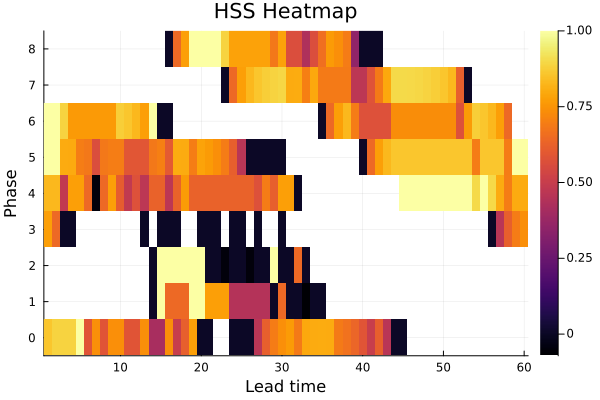

In [136]:
hss_vals = hss(predictions_pc1,predictions_pc2,datasets_test_pc1, datasets_test_pc2)

heatmap(hss_vals,
    #color=:viridis,   # choose your colormap
    title="HSS Heatmap",
    xlabel="Lead time",
    ylabel="Phase",
    na_color=:white,   # color for NaN values
    yticks=(1:9, ["0","1","2","3","4","5","6","7","8"])
)